In [1]:
from calimba.analysis.utilities import add_folder_to_path

add_folder_to_path('/home/anleg84/GitHub/Calimba/')

from utilities import *
from raw import *
from data import *
from atlas import *
from behavior import *
from visualization import *
from timeseries import *

from useful_functions import *
from scipy.stats import percentileofscore
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

%matplotlib inline

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
plt.rcParams['font.size'] = 6

red = 1.1 * np.array([186, 44, 102]) / 255
color1 = [0, 0, 0]
blue = hex2rgb('#006DAA')
color3 = [1, 1, 1]
colormap = make_cmap([color1, blue, color3], [0, 0.5, 1])

# Setting paths

In [3]:
atlas_path = '/home/anleg84/Documents/Atlas/Mapzebrain/'

In [4]:
excluded = [10, 34, 44, 49, 69]

In [5]:
atlas = MapzebrainAtlas(atlas_path)
pixel_sizes = np.array([0.994, 0.994, 0.997])

delete = delete_rows_and_columns

# Computing connectivity matrices

In [6]:
def compute_directed(matrix):
    adjacency = np.copy(matrix)
    for i in range(adjacency.shape[0]):
        for j in range(i + 1, adjacency.shape[0]):
            adjacency[i, j] = adjacency[i, j] / (atlas.relativeVolumes[i] + atlas.relativeVolumes[j])
            adjacency[j, i] = adjacency[j, i] / (atlas.relativeVolumes[i] + atlas.relativeVolumes[j])
    adjacency[adjacency > 0] = np.log10(adjacency[adjacency > 0])
    adjacency[np.diag_indices(adjacency.shape[0])] = 0
    return normalize(adjacency)

def compute_undirected(matrix):
    adjacency = np.copy(matrix)
    for i in range(adjacency.shape[0]):
        for j in range(i + 1, adjacency.shape[0]):
            adjacency[i, j] = (adjacency[i, j] + adjacency[j, i]) / (
                        atlas.relativeVolumes[i] + atlas.relativeVolumes[j])
            adjacency[j, i] = adjacency[i, j]
    adjacency[adjacency > 0] = np.log10(adjacency[adjacency > 0])
    adjacency[np.diag_indices(adjacency.shape[0])] = 0
    return normalize(adjacency)

from scipy.stats import norm, kstest

def evaluate_weights_lognormality(matrix, plot=True):
    data = matrix[matrix != 0]
    mean = np.mean(data)
    std = np.std(data)
    fitted_pdf = norm.pdf(np.sort(data), mean, std)
    _, p_value = kstest(data, 'norm', args=(mean, std))

    if plot:
        fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
        plt.hist(data, bins=50, density=True, color='black', alpha=0.5)
        plt.plot(np.sort(data), fitted_pdf, color='r')
        ax.spines[['top', 'right']].set_visible(False)
        ax.set_xlabel('Connection weight')
        ax.set_ylabel('Probability density')
        plt.show()
        
    return p_value

Loading mapped neuron coordinates

In [7]:
excluded = [10, 34, 44, 49, 69]

FC = np.load('Results/FC_matrix.npy')
triangle = np.triu_indices(65, 1)

# Validating border width for expanded regions

In [21]:
def compute_directed(matrix):
    adjacency = np.copy(matrix)
    for i in range(adjacency.shape[0]):
        for j in range(i + 1, adjacency.shape[0]):
            adjacency[i, j] = adjacency[i, j] / (atlas.relativeVolumes[i] + atlas.relativeVolumes[j])
            adjacency[j, i] = adjacency[j, i] / (atlas.relativeVolumes[i] + atlas.relativeVolumes[j])
    adjacency[adjacency > 0] = np.log10(adjacency[adjacency > 0])
    adjacency[np.diag_indices(adjacency.shape[0])] = 0
    return normalize(adjacency)

def compute_undirected(matrix):
    adjacency = np.copy(matrix)
    for i in range(adjacency.shape[0]):
        for j in range(i + 1, adjacency.shape[0]):
            adjacency[i, j] = (adjacency[i, j] + adjacency[j, i]) / (
                        atlas.relativeVolumes[i] + atlas.relativeVolumes[j])
            adjacency[j, i] = adjacency[i, j]
    adjacency[adjacency > 0] = np.log10(adjacency[adjacency > 0])
    adjacency[np.diag_indices(adjacency.shape[0])] = 0
    return normalize(adjacency)

In [22]:
regions_somas = np.load('Results/regions_somas.npy')
ids_terminals = np.load('Results/ids_terminals.npy')
terminals = np.load('Results/terminals.npy')

In [10]:
x = np.arange(1, 14) * 5
files = []
for value in x:
    files.append('regions_terminals_expanded_{}.npy'.format(value))

In [11]:
matrices = []

for file in files:

    print(file)

    regions_terminals = np.load('Results/' + file)

    connectivity_expanded = np.zeros((70, 70))
    for i in range(terminals.shape[0]):
        if (np.sum(regions_somas[ids_terminals[i], :]) > 0) and (np.sum(regions_terminals[i, :]) > 0):
            r1 = np.where(regions_somas[ids_terminals[i]])[0][0]
            for j in range(regions_terminals.shape[1]):
                if regions_terminals[i, j] > 0:
                    r2 = j
                    connectivity_expanded[r2, r1] += 1
    matrices.append(connectivity_expanded)

regions_terminals_expanded_5.npy
regions_terminals_expanded_10.npy
regions_terminals_expanded_15.npy
regions_terminals_expanded_20.npy
regions_terminals_expanded_25.npy
regions_terminals_expanded_30.npy
regions_terminals_expanded_35.npy
regions_terminals_expanded_40.npy
regions_terminals_expanded_45.npy
regions_terminals_expanded_50.npy
regions_terminals_expanded_55.npy
regions_terminals_expanded_60.npy
regions_terminals_expanded_65.npy


In [12]:
densities = []
for m in matrices:
    rho = (np.sum(m > 0) - m.shape[0]) / (m.shape[0] ** 2 - m.shape[0]) 
    densities.append(rho)

In [13]:
undirected_matrices = [np.load('Data/undirected_terminals.npy')]
for m in matrices:
    M = compute_undirected(m)
    undirected_matrices.append(M)

In [14]:
correlations = []
for m in undirected_matrices:
    r = pearsonr(delete(m, excluded)[triangle], FC[triangle])[0]
    correlations.append(r)

In [15]:
x = [0] + list(x)

In [16]:
x_opt = x[np.argmax(correlations)]

(0.48738177054601173, 0.5778666489568499)

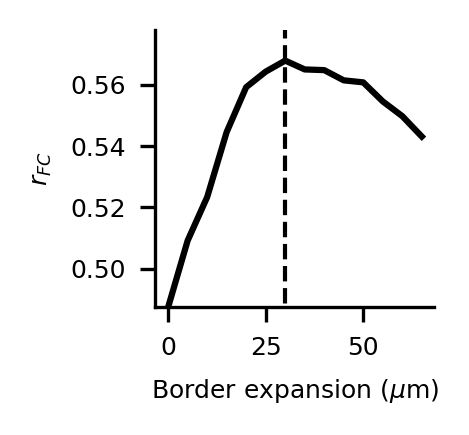

In [17]:
fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
ax.plot(x, correlations, color='black')
ax.spines[['top', 'right']].set_visible(False)
ax.plot([x_opt, x_opt], [0, 1], linestyle='--', color='black', linewidth=1)
plt.xlabel('Border expansion ($\mu$m)')
plt.ylabel(r'$r_{FC}$')
plt.ylim([np.min(correlations), np.max(correlations) + 0.01])
#plt.savefig('/home/anleg84/Documents/Figures/PaperNetworks2024/figuresupp_wiring_expansion_values.svg')

In [18]:
connectivity_optimal = matrices[np.argmax(correlations) - 1]

In [19]:
np.save('Data/raw_terminals_expanded.npy', connectivity_optimal)

In [20]:
undirected = compute_undirected(connectivity_optimal)
directed = compute_directed(connectivity_optimal)

In [21]:
np.save('Data/undirected_terminals_expanded.npy', undirected)
np.save('Data/directed_terminals_expanded.npy', directed)

In [22]:
pearsonr(FC[triangle], delete(undirected, excluded)[triangle])

(0.5678666489568499, 6.628846962991226e-178)

# Null model for expanded region boundaries

In [8]:
connectivity = np.load('Results/raw_connectivity_terminals.npy')
connectivity_expanded = np.load('Results/raw_connectivity_terminals_expanded.npy')

#### Method 1: Shuffling by pathway, pre-normalization

In [74]:
def generate_null_extra_connectivity(raw_counts, values_nonzero, values_zero, zero_only=True):
    
    null_matrix = np.copy(raw_counts)

    raw_values_nonzero = raw_counts[raw_counts > 0]
    added_values = [0] * len(raw_values_nonzero)
    added_values[:len(values_nonzero)] = values_nonzero
    np.random.shuffle(added_values)
    null_matrix[null_matrix > 0] += added_values

    raw_values_zero = raw_counts[raw_counts == 0]
    added_values = [0] * len(raw_values_zero)
    added_values[:len(values_zero)] = values_zero
    np.random.shuffle(added_values)
    null_matrix[null_matrix == 0] += added_values

    return null_matrix

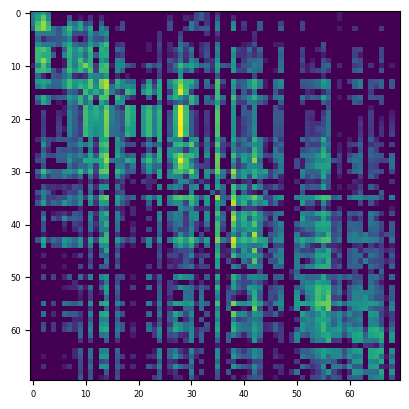

In [75]:
plt.imshow(np.log(connectivity_expanded + 1))

In [76]:
raw_counts = connectivity
extra_counts = connectivity_expanded - connectivity

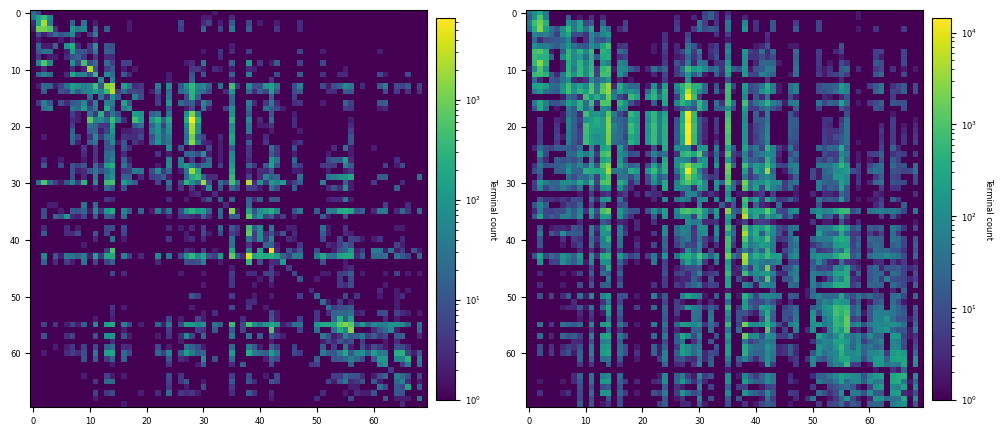

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cax = ax[0].imshow(raw_counts + 1, norm=LogNorm())
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Terminal count', rotation=270, labelpad=12)

cax = ax[1].imshow(extra_counts + 1, norm=LogNorm())
cbar = plt.colorbar(cax, ax=ax[1], fraction=0.045, pad=0.02)
cbar.set_label('Terminal count', rotation=270, labelpad=12)

plt.tight_layout(pad=1)

In [82]:
extra_counts_nonzero = np.copy(extra_counts)
extra_counts_nonzero[raw_counts == 0] = 0

extra_counts_zero = np.copy(extra_counts)
extra_counts_zero[raw_counts > 0] = 0

In [83]:
values_nonzero = extra_counts_nonzero[extra_counts_nonzero > 0]
values_zero = extra_counts_zero[extra_counts_zero > 0]

In [84]:
null_connectivity1 = generate_null_extra_connectivity(raw_counts, values_nonzero, values_zero)

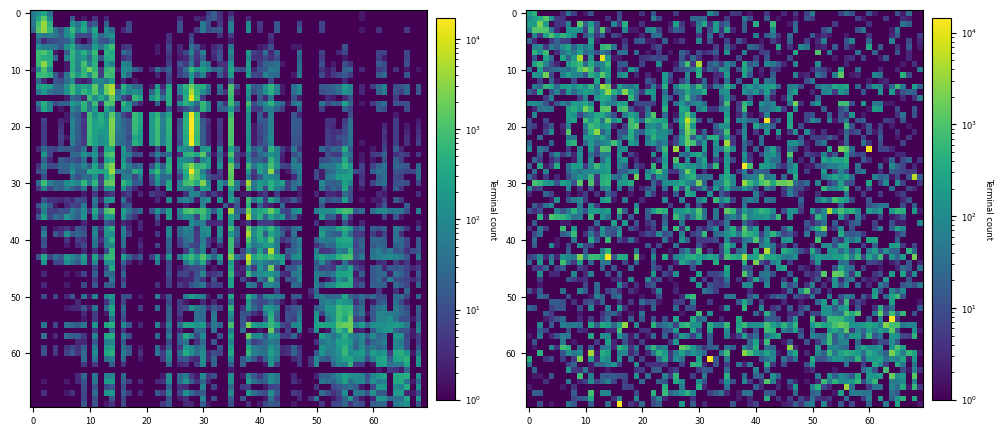

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cax = ax[0].imshow(connectivity_expanded + 1, norm=LogNorm())
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Terminal count', rotation=270, labelpad=12)

cax = ax[1].imshow(null_connectivity1 + 1, norm=LogNorm())
cbar = plt.colorbar(cax, ax=ax[1], fraction=0.045, pad=0.02)
cbar.set_label('Terminal count', rotation=270, labelpad=12)

plt.tight_layout(pad=1)

In [86]:
und_null = delete(compute_undirected(null_connectivity1), excluded)

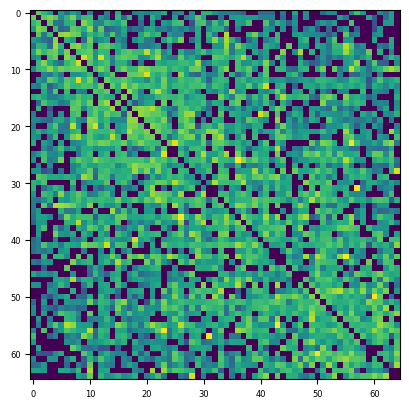

In [87]:
plt.imshow(und_null)

In [88]:
tri = np.triu_indices(65, 1)

In [89]:
pearsonr(und_null[tri], FC[tri])

(0.29917552137653547, 2.844059560278244e-44)

#### Generating null distribution

In [90]:
null_correlations1 = []
for _ in tqdm(range(10000)):
    null_connectivity = generate_null_extra_connectivity(raw_counts, values_nonzero, values_zero)
    und_null = delete(compute_undirected(null_connectivity), excluded)
    r = pearsonr(und_null[tri], FC[tri])[0]
    null_correlations1.append(r)

100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 388.91it/s]


Computing empirical SC-FC correlations

In [93]:
SC_empirical = delete(compute_undirected(connectivity), excluded)
SC_empirical_expanded = delete(compute_undirected(connectivity_expanded), excluded)

In [136]:
r_empirical = pearsonr(FC[tri], SC_empirical[tri])[0]
r_empirical_expanded = pearsonr(FC[tri], SC_empirical_expanded[tri])[0]

#### Method 2: Redistributing every extra terminal count uniformly through zero/non-zero pathways

In [97]:
def sprinkle_random_values(array, total):
    indices = np.random.choice(len(array), size=total_value, replace=True)
    counts = np.bincount(indices, minlength=len(array))
    array += counts
    return array

def generate_null_extra_connectivity(raw_counts, values_nonzero, values_zero):
    
    null_matrix = np.copy(raw_counts)

    total_nonzero = int(np.sum(values_nonzero))
    total_zero = int(np.sum(values_zero))

    raw_values_nonzero = np.copy(raw_counts[raw_counts > 0])
    raw_values_nonzero = sprinkle_random_values(raw_values_nonzero, total_nonzero)
    #for _ in range(total_nonzero):
    #    random_id = int(np.random.uniform(0, len(raw_values_nonzero)))
    #    raw_values_nonzero[random_id] += 1

    raw_values_zero = np.copy(raw_counts[raw_counts == 0])
    #for _ in range(total_zero):
    #    random_id = int(np.random.uniform(0, len(raw_values_zero)))
    #    raw_values_zero[random_id] += 1
    raw_values_zero = sprinkle_random_values(raw_values_zero, total_zero)


    null_matrix[raw_counts > 0] = raw_values_nonzero
    null_matrix[raw_counts == 0] = raw_values_zero
    
    return null_matrix

In [98]:
null_connectivity2 = generate_null_extra_connectivity(raw_counts, values_nonzero, values_zero)

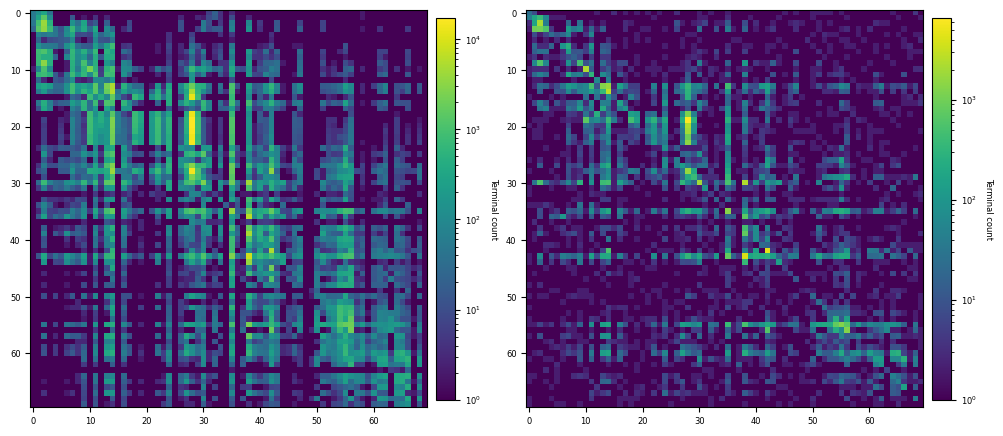

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cax = ax[0].imshow(connectivity_expanded + 1, norm=LogNorm())
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Terminal count', rotation=270, labelpad=12)

cax = ax[1].imshow(null_connectivity2 + 1, norm=LogNorm())
cbar = plt.colorbar(cax, ax=ax[1], fraction=0.045, pad=0.02)
cbar.set_label('Terminal count', rotation=270, labelpad=12)

plt.tight_layout(pad=1)

In [100]:
und_null = delete(compute_undirected(null_connectivity2), excluded)

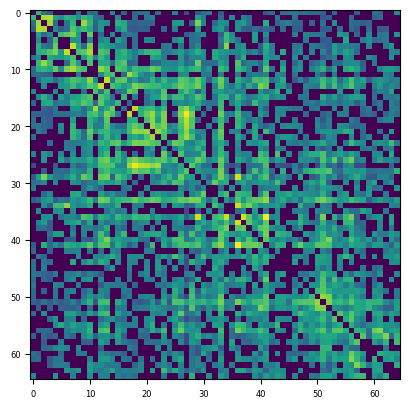

In [101]:
plt.imshow(und_null)

In [102]:
pearsonr(und_null[tri], FC[tri])

(0.3983349305031636, 4.801709128536238e-80)

In [103]:
null_correlations2 = []
for _ in tqdm(range(10000)):
    null_connectivity = generate_null_extra_connectivity(raw_counts, values_nonzero, values_zero)
    und_null = delete(compute_undirected(null_connectivity), excluded)
    r = pearsonr(und_null[tri], FC[tri])[0]
    null_correlations2.append(r)

100%|████████████████████████████████████| 10000/10000 [00:21<00:00, 458.46it/s]


# Making figure

In [115]:
red = 1.1 * np.array([186, 44, 102]) / 255
blue = hex2rgb('#006DAA')

cmap_red = make_cmap([[0,0,0], red, [1,1,1]], [0, 0.5, 1])
cmap_blue = make_cmap([[0,0,0], blue, [1,1,1]], [0, 0.5, 1])

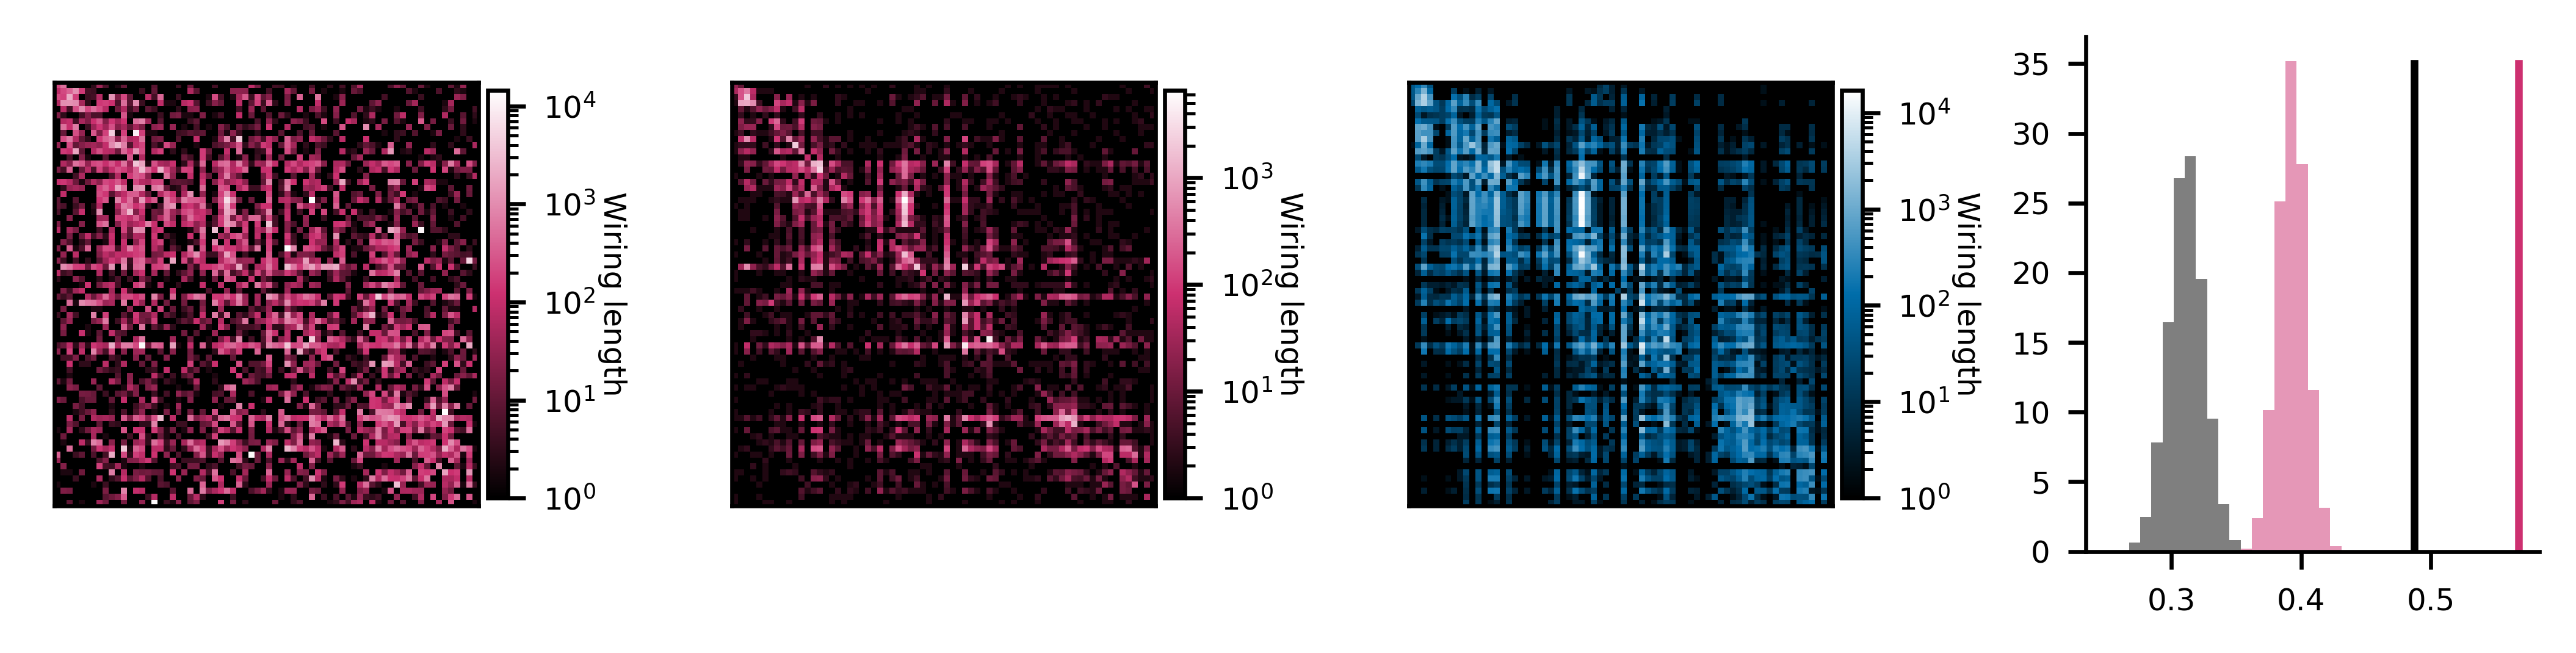

In [138]:
fig, axes = plt.subplots(1, 4, figsize=(7, 7/4), dpi=600)

labelpad = 6

ax = axes[0]
cax = ax.imshow(null_connectivity1 + 1, norm=LogNorm(), cmap=cmap_red)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
cbar.set_label('Wiring length', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1]
cax = ax.imshow(null_connectivity2 + 1, norm=LogNorm(), cmap=cmap_red)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
cbar.set_label('Wiring length', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[2]
cax = ax.imshow(connectivity_expanded + 1, norm=LogNorm(), cmap=cmap_blue)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
cbar.set_label('Wiring length', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

bins = np.linspace(0.25, 0.5, 30)
ax = axes[3]
ax.hist(null_correlations1, facecolor='black', edgecolor='None', alpha=0.5, density=True, bins=bins)
ax.hist(null_correlations2, facecolor=red, edgecolor='None', alpha=0.5, density=True, bins=bins)
ax.plot([r_empirical, r_empirical], [0, 35], color='black')
ax.plot([r_empirical_expanded, r_empirical_expanded], [0, 35], color=red)

ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout(pad=1)

plt.savefig('/home/anleg84/Documents/Figures/PaperNetworks2024/figuresupp_wiring_nullmodels.svg')

In [145]:
from scipy.stats import norm

In [148]:
mean = np.mean(null_correlations2)
std = np.std(null_correlations2)

z_score = (r_empirical - mean) / std
p_value = 1 - norm.cdf(z_score)
print(p_value)

0.0
